In [6]:
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import georaster
from skimage.draw import polygon
import numpy as np

In [4]:
project_dir = '/home/hgamarro/DeepLearning/HG_space'
root_dir = str(project_dir) + '/data/processed/Vegas/train'
inputs = list(os.listdir(f"{root_dir}/images/"))

In [25]:
image_filename = inputs[223]

# Load image
image = np.load(os.path.join(root_dir, "images", image_filename))
# image = torch.Tensor(image).permute(2, 0, 1)[None, :, :, :] ##Converts to 1,C,H,W

# Load masks
mask = np.load(os.path.join(root_dir, "masks", image_filename.replace(".npy", "_mask.npy")))
mask = (mask > 0).astype(np.int32)


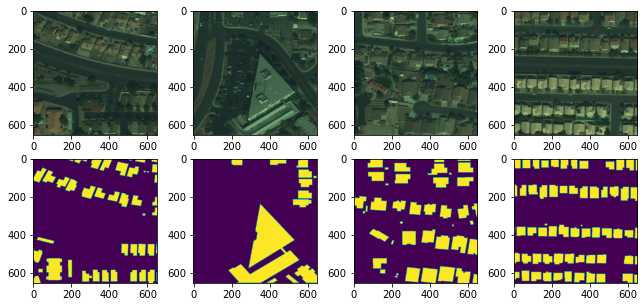

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(11, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,4):
    
    image_filename = inputs[a+15]

    # Load image
    image = np.load(os.path.join(root_dir, "images", image_filename))
    # image = torch.Tensor(image).permute(2, 0, 1)[None, :, :, :] ##Converts to 1,C,H,W

    # Load masks
    mask = np.load(os.path.join(root_dir, "masks", image_filename.replace(".npy", "_mask.npy")))
    mask = (mask > 0).astype(np.int32)

    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [ ]:
directory = 'tiles'

files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
files_img = list(filter(re.compile(pattern_img).match,files))

pattern_mask = '.*\.tif'
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

 All files: 7702
 Image files: 3851
 Mask files: 3851


In [ ]:
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

df_files = df_files.sample(frac=1,random_state=10)

train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

 Train examples: 2695
 Validation examples: 578
 Test examples: 578




Image and respective mask examples

Found 10 validated image filenames.
Found 10 validated image filenames.


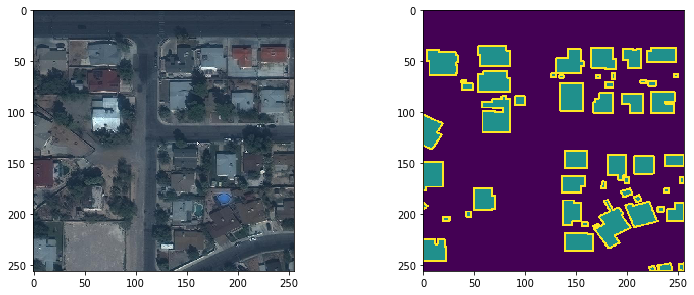

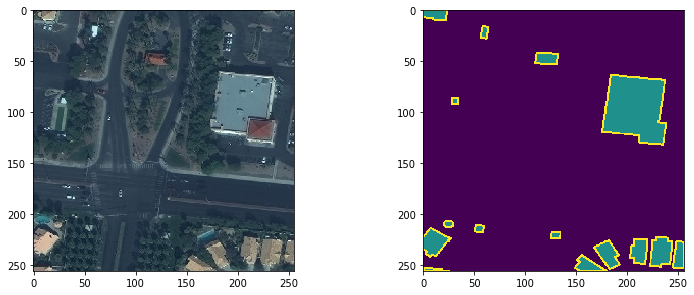

In [ ]:
def make_tuple_gen(df_files,target_size,batch_size,seed):

  img_gen = keras.preprocessing.image.ImageDataGenerator()
     
  img_generator = img_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb')
  
  mask_gen = keras.preprocessing.image.ImageDataGenerator()

  mask_generator = mask_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='mask',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='grayscale')


  return zip(img_generator, mask_generator)

def make_gen4unet(df_files,target_size = (256, 256),batch_size = 1,seed = 10):
  
  tuple_gen =  make_tuple_gen(df_files,target_size,batch_size,seed)

  def _gen():  
    while True:
      x,y = next(tuple_gen)
      
      y[y==100] = 1
      y[y==255] = 2

      yield x,y

  return _gen()

print('\nImage and respective mask examples\n')

genUnet = make_gen4unet(df_files.head(10))
for i in range(2):
  xx,yy = next(genUnet)
  xx = xx[0].astype(int)
  yy = np.squeeze(yy[0].astype(int))


  plt.figure(figsize=1*np.array([2*6.4, 4.8]))
  plt.subplot(121)
  plt.imshow(xx)
  plt.subplot(122)
  plt.imshow(yy)
  plt.show()